<a href="https://colab.research.google.com/github/sabin5105/CIFAR10/blob/main/hyperparameter_tuning/Cnn_hyperparameter_tuning_learningrate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras-tuner
from warnings import filterwarnings
filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 4.0 MB/s 
     |████████████████████████████████| 1.6 MB 31.2 MB/s 


In [2]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
import numpy as np
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt

In [3]:
cifar=keras.datasets.cifar10
(X_train,y_train),(X_test,y_test)=cifar.load_data()

170498071/170498071 [==============================] - 11s 0us/step


In [4]:
X_train=X_train/255.0
X_test=X_test/255.0

In [5]:
n=len(np.unique(y_test))
n

10

In [6]:
y_train=to_categorical(y_train,n)
y_test=to_categorical(y_test,n)

In [7]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

In [8]:
def build_model(hp):
    model=Sequential()

    #Buiding the convolutional layer
    model.add(Conv2D(filters=32, kernel_size=3,activation='relu',input_shape=(32,32,3)))
    model.add(MaxPooling2D(pool_size=2))
    #adding the second layer
    model.add(Conv2D(filters=64,kernel_size=3,activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=64,kernel_size=3,activation='relu'))
    #Flattening the feature map
    model.add(Flatten())

    #Adding ANN layers 
    model.add(Dense(units=64,activation='relu'))
   
    #adding the final layer
    model.add(Dense(units=10,activation='softmax'))

    #compiling the model
    model.compile(optimizer=keras.optimizers.Adam(
                hp.Float(
                    "learning_rate",
                    min_value=1e-4,
                    max_value=1e-2,
                    sampling="LOG",
                    default=1e-3,
                )
            ),loss='categorical_crossentropy',metrics=['accuracy'])
    return model

In [9]:
tuner=RandomSearch(build_model,
                   objective='val_accuracy',
                   max_trials=3
                  )

In [10]:
tuner.search(X_train,y_train,epochs=3,validation_split=0.2,verbose=2)

Trial 3 Complete [00h 03m 02s]
val_accuracy: 0.6035000085830688

Best val_accuracy So Far: 0.6212999820709229
Total elapsed time: 00h 09m 32s


In [11]:
model=tuner.get_best_models(num_models=1)[0]

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)              0

In [13]:
answer=model.fit(X_train,y_train,epochs=10,initial_epoch=3,validation_split=0.2)

Epoch 4/10
1250/1250 [==============================] - 65s 51ms/step - loss: 1.0021 - accuracy: 0.6485 - val_loss: 1.0553 - val_accuracy: 0.6344
Epoch 5/10
1250/1250 [==============================] - 63s 51ms/step - loss: 0.9226 - accuracy: 0.6758 - val_loss: 0.9633 - val_accuracy: 0.6643
Epoch 6/10
1250/1250 [==============================] - 63s 51ms/step - loss: 0.8661 - accuracy: 0.6978 - val_loss: 0.9584 - val_accuracy: 0.6714
Epoch 7/10
1250/1250 [==============================] - 63s 51ms/step - loss: 0.8078 - accuracy: 0.7192 - val_loss: 0.8976 - val_accuracy: 0.6916
Epoch 8/10
1250/1250 [==============================] - 64s 51ms/step - loss: 0.7631 - accuracy: 0.7330 - val_loss: 0.8878 - val_accuracy: 0.6945
Epoch 9/10
1250/1250 [==============================] - 63s 51ms/step - loss: 0.7174 - accuracy: 0.7507 - val_loss: 0.9045 - val_accuracy: 0.6914
Epoch 10/10
1250/1250 [==============================] - 63s 51ms/step - loss: 0.6823 - accuracy: 0.7615 - val_loss: 0.9131 

In [14]:
model.evaluate(X_test,y_test)

313/313 [==============================] - 5s 15ms/step - loss: 0.9260 - accuracy: 0.6910


[0.9260171055793762, 0.6909999847412109]

In [15]:
pred = model.predict(X_test)

313/313 [==============================] - 6s 18ms/step


In [16]:
from sklearn.metrics import *
import numpy as np

pred = np.argmax(pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)
print("Accuracy: ", accuracy_score(y_test, pred))
print("F1 Score: ", f1_score(y_test, pred, average='macro'))
print("Recall: ", recall_score(y_test, pred, average='macro'))
print("Precision: ", precision_score(y_test, pred, average='macro'))
print("-"*70)

Accuracy:  0.691
F1 Score:  0.691159251394982
Recall:  0.6910000000000001
Precision:  0.7073215956397327
----------------------------------------------------------------------


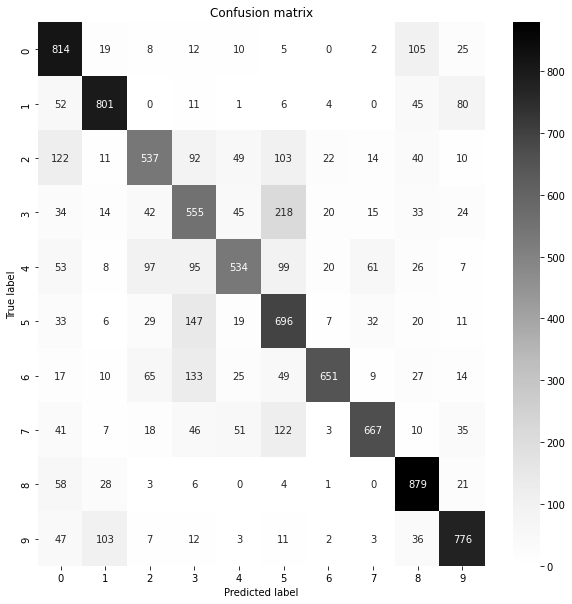

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap='Greys')
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [18]:
from sklearn.metrics import classification_report
print("Classification Report: ", classification_report(y_test, pred))

Classification Report:                precision    recall  f1-score   support

           0       0.64      0.81      0.72      1000
           1       0.80      0.80      0.80      1000
           2       0.67      0.54      0.59      1000
           3       0.50      0.56      0.53      1000
           4       0.72      0.53      0.61      1000
           5       0.53      0.70      0.60      1000
           6       0.89      0.65      0.75      1000
           7       0.83      0.67      0.74      1000
           8       0.72      0.88      0.79      1000
           9       0.77      0.78      0.77      1000

    accuracy                           0.69     10000
   macro avg       0.71      0.69      0.69     10000
weighted avg       0.71      0.69      0.69     10000

